In [1]:
######################################################################################
Copyright (c) 2023, 2024 , Prof. Radhamadhab Dalai, ITER , Siksha O Aanusandhan University, 
Odisha, India
Author's email address :  radhamadhabdalai@soa.ac.in
#####################################################################################

import numpy as np 
import pandas as pd 


!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs

import matplotlib.pyplot as plt
from PIL import Image
import imageio
import pathlib
import time
import PIL
import glob
from IPython import display

import tensorflow as tf
from tensorflow.keras import layers
tf.__version__


ERROR: Package 'tensorflow-docs' requires a different Python: 3.8.19 not in '>=3.9'


2024-05-16 11:02:39.820204: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-16 11:02:39.899254: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-16 11:02:40.474275: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-16 11:02:40.477883: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-16 11:02:41.397289: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

'2.13.1'

(218, 178, 3)
Total images :  202599
b'data/celeb_k/img_align_celeba/img_align_celeba/125135.jpg'
b'data/celeb_k/img_align_celeba/img_align_celeba/102851.jpg'
b'data/celeb_k/img_align_celeba/img_align_celeba/175497.jpg'
b'data/celeb_k/img_align_celeba/img_align_celeba/138190.jpg'
b'data/celeb_k/img_align_celeba/img_align_celeba/110038.jpg'


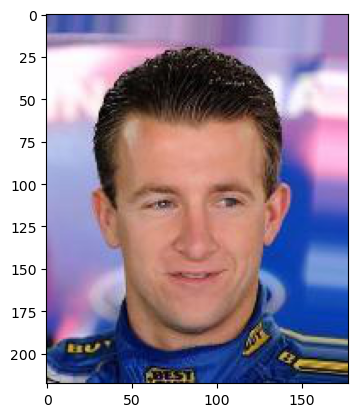

In [19]:
test_image = np.array(Image.open('data/celeb_k/img_align_celeba/img_align_celeba/000023.jpg'))
print(test_image.shape)
plt.imshow(test_image)

data_dir = pathlib.Path('data/celeb_k/img_align_celeba/img_align_celeba/')
image_count = len(list(data_dir.glob('*.jpg')))
print("Total images : ",image_count)

IMAGE_HEIGHT = 104
IMAGE_WIDTH = 88
GENERATOR_IMAGE_HEIGHT = 13
GENERATOR_IMAGE_WIDTH = 11
NOISE_DIM = 100
VAL_SPLIT = 0.2

list_data = tf.data.Dataset.list_files(str(data_dir/'*.jpg'), shuffle=False)
list_data = list_data.shuffle(image_count,reshuffle_each_iteration=False)

for f in list_data.take(5):
    print(f.numpy())

val_size = int(image_count*VAL_SPLIT)
train_ds_list = list_data.skip(val_size)
val_ds_list = list_data.take(val_size)

# A funtion to plot the preprocessed image
def plot_image(processed_image):
    processed_image = processed_image * 255
    img = tf.cast(processed_image, dtype=tf.uint8)
    plt.imshow(img)

def get_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, [IMAGE_HEIGHT, IMAGE_WIDTH])
    img = img / 255
    return img


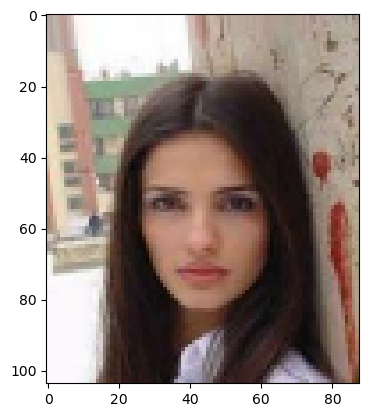

In [20]:
plot_image(get_image('data/celeb_k/img_align_celeba/img_align_celeba/000026.jpg'))



# plot_image(get_image('data/celeb_a/img_align_celeba/img_align_celeba/000026.jpg')
train_ds = train_ds_list.map(get_image)
val_ds = val_ds_list.map(get_image)

BATCH_SIZE = 32

def configure_for_performance(ds):
#     ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

Image Shape:  (1, 104, 88, 3)
Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 104, 88, 3)]      0         
                                                                 
 cnn_block (CNNBlock)        multiple                  2432      
                                                                 
 cnn_block_1 (CNNBlock)      multiple                  51264     
                                                                 
 cnn_block_2 (CNNBlock)      multiple                  204928    
                                                                 
 cnn_block_3 (CNNBlock)      multiple                  819456    
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense_1 (Dense)       

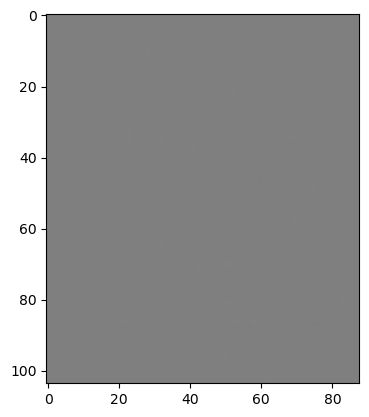

In [21]:

IMAGE_HEIGHT = 104
IMAGE_WIDTH = 88
GENERATOR_IMAGE_HEIGHT = 13
GENERATOR_IMAGE_WIDTH = 11
NOISE_DIM = 100
VAL_SPLIT = 0.2
BATCH_SIZE = 32
class Upsample(tf.keras.Model):
    def __init__(self, filters, kernel, stride ):
        super(Upsample,self).__init__()
        self.filters = filters
        self.conv2DT = layers.Conv2DTranspose(self.filters, kernel_size = (kernel,kernel), strides=(stride,stride), padding='same', use_bias = 'false')
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU()
    
    def call(self, inputs):
        # input shape - (batch_size, x , y, z)
        x = self.conv2DT(inputs)
        x = self.batchnorm(x)
        out = self.lrelu(x)
        return out
        # output shape - (batch_size, 2x , 2y, self.filters)

# For the sake of understanding consider initial filters to be 256 and generator image height and generator image width to be 13 and 11 respectively 
# and follow the comments
class Generator(tf.keras.Model):
    #                   13      11      256          5
    def __init__(self,height, width, init_filters, kernel):
        super(Generator,self).__init__()
        self.dense = layers.Dense(height*width*init_filters, use_bias=False, input_shape=(NOISE_DIM,))
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU()
        self.reshape = layers.Reshape((height, width, init_filters))
        self.upsample1 = Upsample(init_filters,kernel,1)
        self.upsample2 = Upsample(init_filters/2,kernel,2)
        self.upsample3 = Upsample(init_filters/4,kernel,2)
        self.convtranspose = layers.Conv2DTranspose(3,(kernel,kernel), strides=(2,2), use_bias='false',padding='same', activation='sigmoid')
        
    def call(self, inputs):
        # input shape - (batch_size, 100)
        x = self.dense(inputs)
        # shape - (batch_size, 13*11*256)
        x = self.batchnorm(x)
        x = self.lrelu(x)
        x = self.reshape(x)
        # shape - (batch_size, 13, 11, 256)
        x = self.upsample1(x)
        # shape - (batch_size, 13, 11, 256)
        x = self.upsample2(x)
        # shape - (batch_size, 26, 22, 128)
        x = self.upsample3(x)
        # shape - (batch_size, 52, 44, 64)
        out = self.convtranspose(x)
        # shape - (batch_size, 104, 88, 3)
        return out

generator = Generator(GENERATOR_IMAGE_HEIGHT,GENERATOR_IMAGE_WIDTH,256,5)

# Testing how generator generates now
noise = tf.random.normal([1,NOISE_DIM])
generated_image = generator(noise,training=False)
print("Image Shape: ",generated_image.shape)
plt.imshow(generated_image[0])

# This is one CNN block during downnsampling
class CNNBlock(tf.keras.Model):
    def __init__(self, filters, kernel, stride):
        super(CNNBlock, self).__init__()
        self.conv = layers.Conv2D(filters, kernel_size = (kernel,kernel), strides = (stride, stride), padding='same')
        self.lrelu = layers.LeakyReLU()
        self.dropout = layers.Dropout(0.3)
        
    def call(self, inputs):
        x = self.conv(inputs)
        x = self.lrelu(x)
        out = self.dropout(x)
        return out

#o be 104 and 88 respectively 
# and follow the comments
class Discriminator(tf.keras.Model):
    #                      32          5
    def __init__(self, init_filters, kernel):
        super(Discriminator,self).__init__()
        self.input_layer = layers.InputLayer(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH,3))
        self.cnn1 = CNNBlock(init_filters, kernel, 1)
        self.cnn2 = CNNBlock(init_filters*2, kernel, 2)
        self.cnn3 = CNNBlock(init_filters*4, kernel, 1)
        self.cnn4 = CNNBlock(init_filters*8, kernel, 1)
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(1)
        
    def call(self, inputs):
        # shape - (batch_size, 104, 88,3)
        x = self.input_layer(inputs)
        # shape - (batch_size, 104, 88,3)
        x = self.cnn1(x)
        # shape - (batch_size, 104, 88, 32)
        x = self.cnn2(x)
        # shape - (batch_size, 52, 44, 64)
        x = self.cnn3(x)
        # shape - (batch_size, 52, 44, 128)
        x = self.cnn4(x)
        # shape - (batch_size, 52, 44, 256)
        x = self.flatten(x)
        # shape - (batch_size, 52 * 44 * 256)
        out = self.dense(x)
        # shape - (batch_size, 1)
        return out

discriminator = Discriminator(32, 5)

discriminator.build((BATCH_SIZE,IMAGE_HEIGHT, IMAGE_WIDTH,3))
discriminator.summary()

#Loss functions for generator and discriminator
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    return real_loss + fake_loss

#Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

EPOCHS = 40
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, NOISE_DIM])

seed = tf.random.normal([num_examples_to_generate, NOISE_DIM])

# This is used to generate images during training and saving them for final GIF
def generate_and_save_images(model, epoch,step, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        image = tf.cast(predictions[i, :, :]*255.0,dtype=tf.uint8)
        plt.imshow(image)
        plt.axis('off')
    
    plt.savefig('image_at_epoch_{:04d}_step_{:06d}.png'.format(epoch, step))
    plt.show()

In [22]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE,NOISE_DIM])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        fake_output = discriminator(generated_images, training=True)
        real_output = discriminator(images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_disc= disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_gen, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_disc, discriminator.trainable_variables))

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for i,image_batch in enumerate(dataset):
            train_step(image_batch)
#             if (i%100==0):
#                 display.clear_output(wait=True)
#                 print("{}th batch done".format(i))
#             if (i%500==0):
#                 display.clear_output(wait=True)
#                 generate_and_save_images(generator, epoch, i, seed)
        
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch, 9999, seed)
        
#         checkpoint.save(file_prefix = checkpoint_prefix)
        generator.save_weights('generator_weights_epoch_{}'.format(epoch))
            
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch, 55000, seed)

# I use this section to clear the GPU memory so that I can reuse GPU again
# !pip install GPUtil

# from GPUtil import showUtilization as gpu_usage
# gpu_usage()

# import torch
# torch.cuda.empty_cache()

# gpu_usage()
# from numba import cuda
# cuda.select_device(0)
# cuda.close()
# gpu_usage()


start = time.time()
train(train_ds, EPOCHS)
print('Total Training Time is {} sec'.format(time.time()-start))

def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    ##check here
    # image = imageio.imread(filename)
    # writer.append_data(image)

import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

generator.load_weights('../input/generator-weights-39/generator_weights_epoch_39')
random = tf.random.normal([1,100])
plt.imshow(tf.reshape(random,(10,10)))
plt.show()
image = generator.predict(random)
plt.imshow(image[0])

discriminator.save_weights('discrimininator_weights_checkpoint')


NameError: name 'filename' is not defined